In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_all = pd.read_csv("../data/TwoBarTruss.csv", delimiter=';')

In [2]:
df_all.head()

,Volume,MaxStress,x1,x2,y,g1,Feasible
0,0.021916,18377.203009,0.002354,0.004815,2.115106,-81622.796991,1
1,0.031101,12991.022813,0.003331,0.006803,2.129376,-87008.977187,1
2,0.008704,46119.773223,0.000961,0.001948,2.022885,-53880.226777,1
3,0.038300,10514.420370,0.004061,0.008395,2.145074,-89485.579630,1
4,0.037292,10759.938300,0.004219,0.008331,1.977927,-89240.061700,1


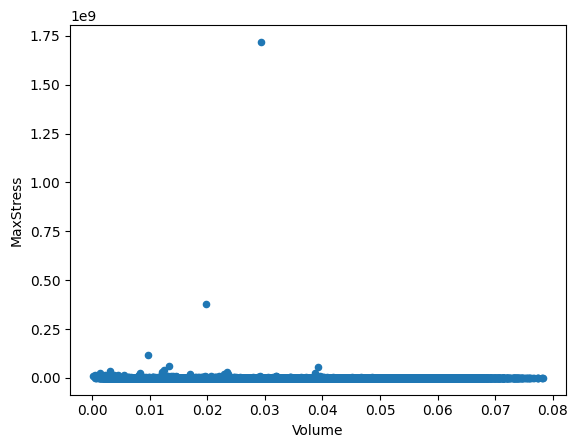

In [3]:
df_all.plot(kind="scatter", x="Volume", y="MaxStress")
plt.show()

In [4]:
from desdeo_tools.utilities import non_dominated

non_dom_inds = non_dominated(df_all[["Volume", "MaxStress"]].values)
df_nondom = df_all[non_dom_inds].copy()
print(df_nondom.shape[0])
df_nondom.head()

521


,Volume,MaxStress,x1,x2,y,g1,Feasible
0,0.021916,18377.203009,0.002354,0.004815,2.115106,-81622.796991,1
1,0.031101,12991.022813,0.003331,0.006803,2.129376,-87008.977187,1
2,0.008704,46119.773223,0.000961,0.001948,2.022885,-53880.226777,1
3,0.038300,10514.420370,0.004061,0.008395,2.145074,-89485.579630,1
4,0.037292,10759.938300,0.004219,0.008331,1.977927,-89240.061700,1


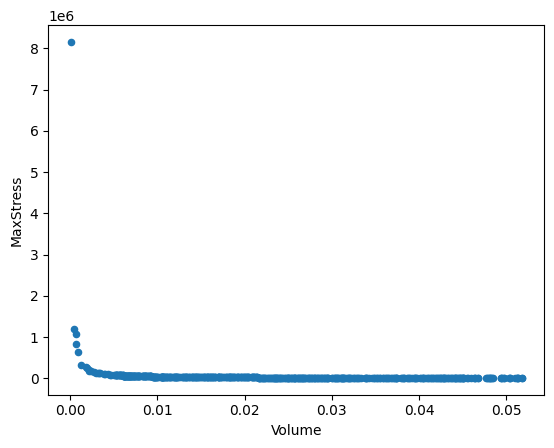

In [5]:
df_nondom.plot(kind="scatter", x="Volume", y="MaxStress")
plt.show()

In [6]:
class_1_mask = df_nondom["MaxStress"] > 0.1e6
class_2_mask = np.logical_and(df_nondom["Volume"] < 0.022, df_nondom["MaxStress"] < 0.1e6)
class_3_mask = np.logical_and(df_nondom["Volume"] > 0.022, df_nondom["MaxStress"] < 0.1e6)

print(f"Sum of masks {class_1_mask.sum() + class_2_mask.sum() + class_3_mask.sum()}, sum of data {df_nondom.shape[0]}")

Sum of masks 521, sum of data 521


In [7]:
df_nondom.loc[class_1_mask, "class"] = 1
df_nondom.loc[class_2_mask, "class"] = 2
df_nondom.loc[class_3_mask, "class"] = 3

df_nondom.head()

,Volume,MaxStress,x1,x2,y,g1,Feasible,class
0,0.021916,18377.203009,0.002354,0.004815,2.115106,-81622.796991,1,2.0
1,0.031101,12991.022813,0.003331,0.006803,2.129376,-87008.977187,1,3.0
2,0.008704,46119.773223,0.000961,0.001948,2.022885,-53880.226777,1,2.0
3,0.038300,10514.420370,0.004061,0.008395,2.145074,-89485.579630,1,3.0
4,0.037292,10759.938300,0.004219,0.008331,1.977927,-89240.061700,1,3.0


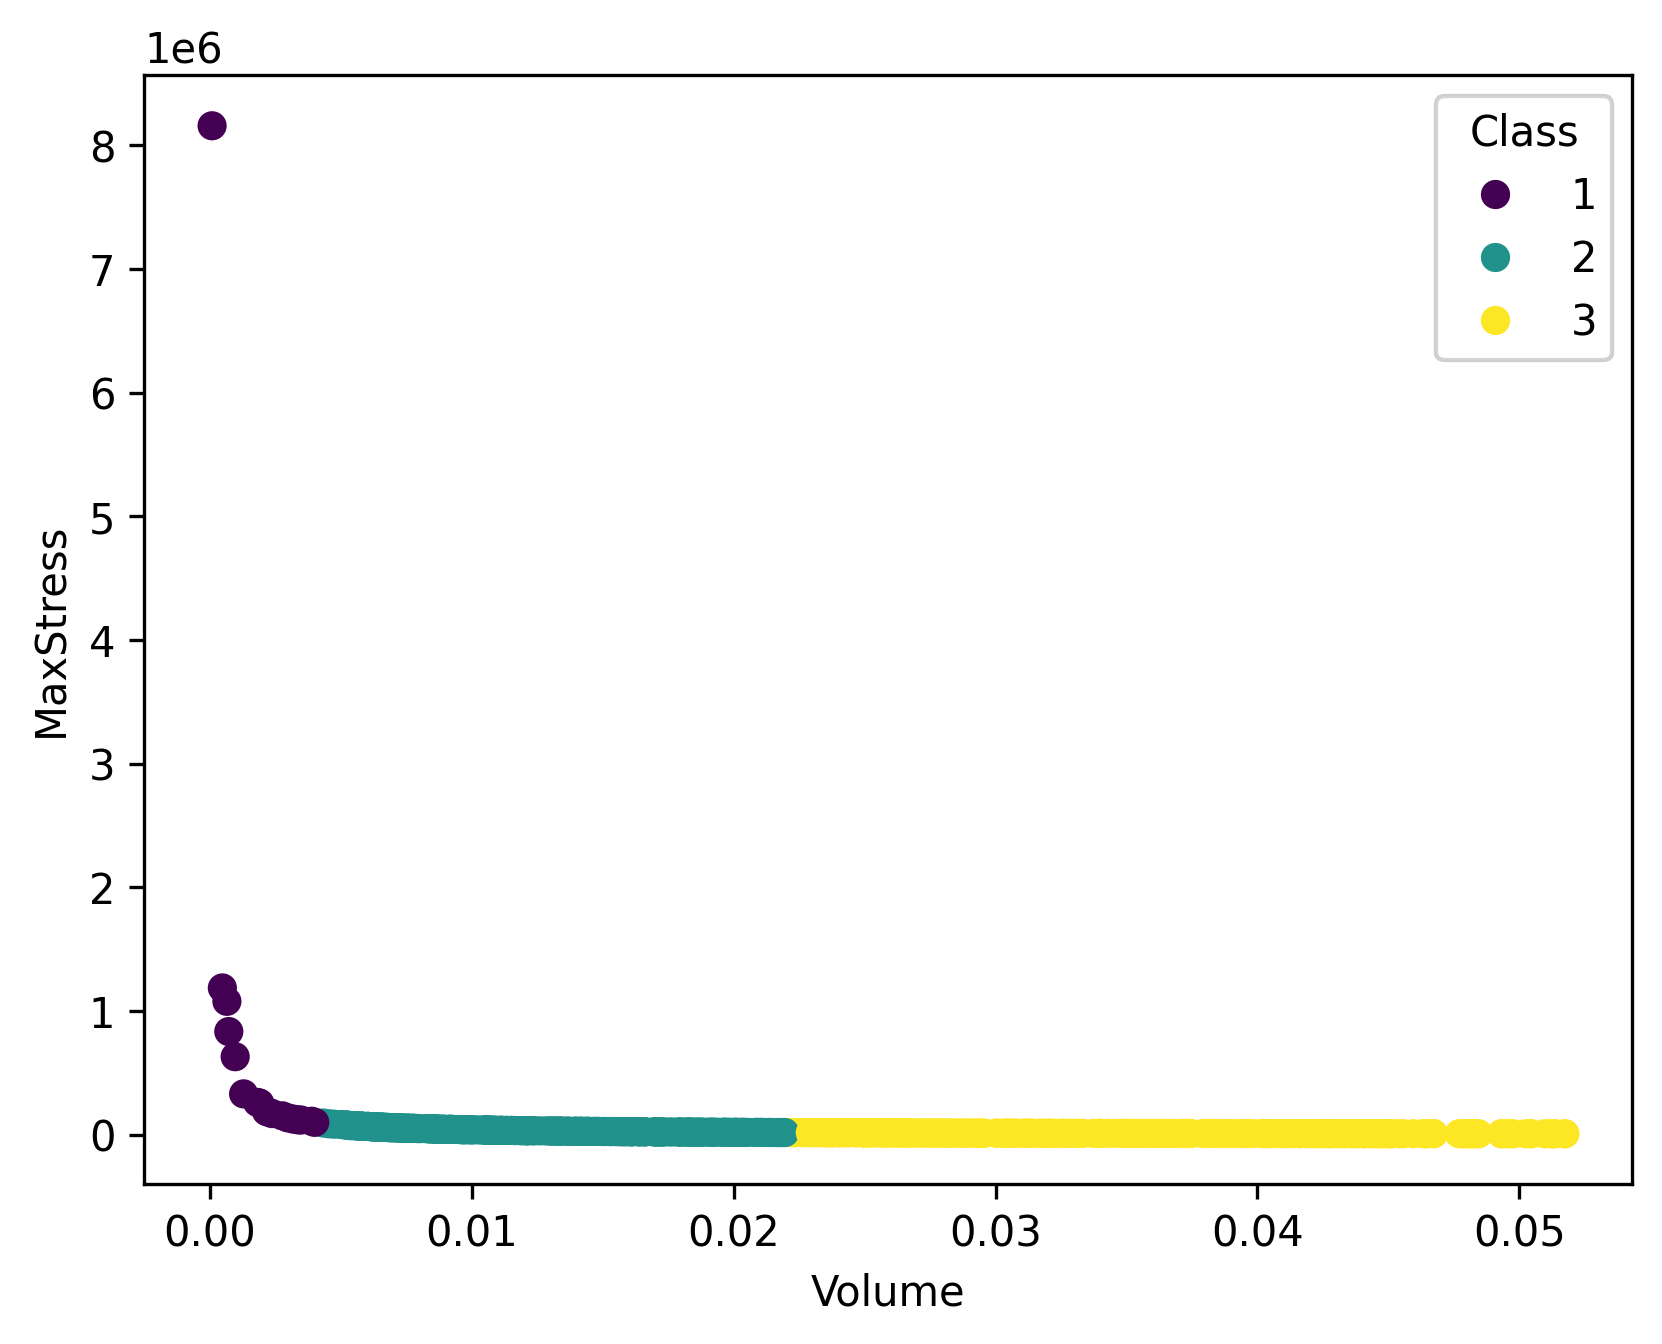

In [22]:
sc = plt.scatter(x=df_nondom["Volume"], y=df_nondom["MaxStress"], c=df_nondom["class"])

plt.xlabel("Volume")
plt.ylabel("MaxStress")

legend = plt.legend(*sc.legend_elements(), title="Class")
plt.gca().add_artist(legend)

plt.show()

In [23]:
xs = df_nondom[["x1", "x2", "y"]].copy().reset_index(drop=True)  # keep indices ordinal
ys = df_nondom[["class"]].copy().reset_index(drop=True)

print(xs.head())
print(ys.head())

         x1        x2         y
0  0.002354  0.004815  2.115106
1  0.003331  0.006803  2.129376
2  0.000961  0.001948  2.022885
3  0.004061  0.008395  2.145074
4  0.004219  0.008331  1.977927
   class
0    2.0
1    3.0
2    2.0
3    3.0
4    3.0


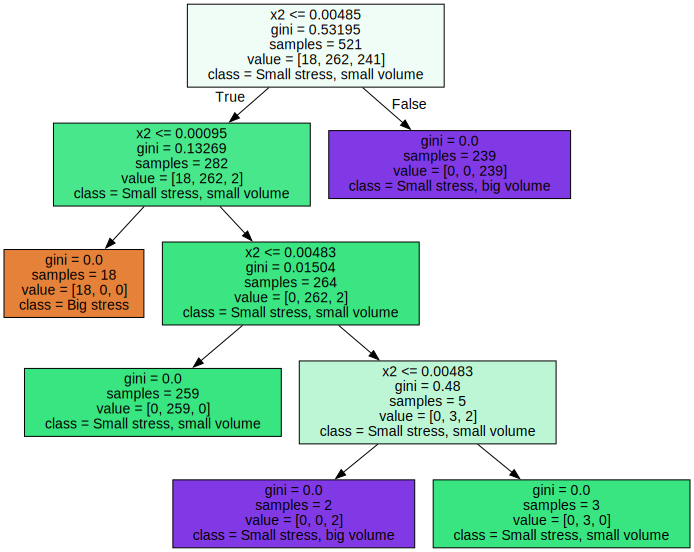

In [37]:
# from imodels import FIGSClassifier as Classifier
from sklearn import tree
Classifier = tree.DecisionTreeClassifier
from imodels.discretization import ExtraBasicDiscretizer as Discretizer
import graphviz

"""
discretizer = Discretizer(["x1", "x2", "y"])
discretizer.fit(xs)
xs_discrete = discretizer.transform(xs)
"""

classifier = Classifier(max_leaf_nodes=10)
classifier.fit(xs, ys)

dot_data = tree.export_graphviz(classifier, out_file=None, 
                     feature_names=["x1", "x2", "y"],  
                     class_names=["Big stress", "Small stress, small volume", "Small stress, big volume"],  
                     filled=True, rounded=False, precision=5,  
                     special_characters=False)  
graph = graphviz.Source(dot_data)  
graph 

In [33]:
print(tree.export_text(classifier, decimals=5))

|--- feature_1 <= 0.00485
|   |--- feature_1 <= 0.00095
|   |   |--- class: 1.0
|   |--- feature_1 >  0.00095
|   |   |--- feature_1 <= 0.00483
|   |   |   |--- class: 2.0
|   |   |--- feature_1 >  0.00483
|   |   |   |--- feature_1 <= 0.00483
|   |   |   |   |--- class: 3.0
|   |   |   |--- feature_1 >  0.00483
|   |   |   |   |--- class: 2.0
|--- feature_1 >  0.00485
|   |--- class: 3.0

